#Frequency Response Forecasting for Battery Storage
This report outlines the methodology used for forecasting dynamic frequency response (DFR) service prices. The approach involves careful data preprocessing, advanced feature engineering, and a robust time-series modeling framework.

##1. Data Preprocessing
The initial phase focuses on collecting, cleaning, aligning, and merging multiple datasets from various sources. The key steps include:

###Data Loading and Concatenation:

Multiple CSV files from different periods (2023 and 2024) are loaded.

Data from similar sources (e.g., Day-Ahead Price, Generation by Fuel, etc.) are concatenated to create continuous time series.

###Timestamp Handling:

Columns containing timestamp information are renamed to a common name (timestamp).

Timestamps are converted to datetime objects using a UK-style format ('%d/%m/%Y %H:%M'), ensuring consistency across datasets.

###Missing Value Treatment:

Missing values are managed using forward-fill (ffill) and back-fill (bfill) techniques to maintain data continuity.

###Resampling and Alignment:

All datasets are resampled into 4-hour “EFA blocks” to synchronize the different data sources.

The resampled data is merged on the common timestamp, ensuring that every feature is aligned for subsequent analysis.

This preprocessing ensures that diverse datasets with varying frequencies are standardized, cleaned, and synchronized before any further analysis is conducted.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install scikit-optimize sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 12.7 MB/s eta 0:00:00


In [3]:
# ========================
# 1. Data Preprocessing
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import shap
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sktime.split import ExpandingWindowSplitter
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load and concatenate datasets
def load_and_preprocess():
    # Ensure proper time alignment and merging
    # Load CSV files into DataFrames
    day_ahead_price_2023 = pd.read_csv('/content/drive/MyDrive/Hackaton/Data/Day-Ahead Price (1H)_2023.csv')
    day_ahead_price_2024 = pd.read_csv('/content/drive/MyDrive/Hackaton/Data/Day-Ahead Price (1H)_2024.csv')
    generation_by_fuel_2023 = pd.read_csv('/content/drive/MyDrive/Hackaton/Data/Generation by Fuel_2023.csv')
    generation_by_fuel_2024 = pd.read_csv('/content/drive/MyDrive/Hackaton/Data/Generation by Fuel_2024.csv')
    mel_below_pn_2023 = pd.read_csv('/content/drive/MyDrive/Hackaton/Data/MEL below PN_2023.csv')
    mel_below_pn_2024 = pd.read_csv('/content/drive/MyDrive/Hackaton/Data/MEL below PN_2024.csv')
    frequency_2023 = pd.read_csv('/content/drive/MyDrive/Hackaton/Data/Frequency_2023.csv')
    frequency_2024 = pd.read_csv('/content/drive/MyDrive/Hackaton/Data/Frequency_2024.csv')
    ancillary_volumes_prices_2023 = pd.read_csv('/content/drive/MyDrive/Hackaton/Data/Ancillary Volumes & Prices (4H)_2023.csv')
    ancillary_volumes_prices_2024 = pd.read_csv('/content/drive/MyDrive/Hackaton/Data/Ancillary Volumes & Prices (4H)_2024.csv')
    prices_forecasts_2023 = pd.read_csv('/content/drive/MyDrive/Hackaton/Data/Prices & Forecasts (HH)_2023.csv')
    prices_forecasts_2024 = pd.read_csv('/content/drive/MyDrive/Hackaton/Data/Prices & Forecasts (HH)_2024.csv')

    # Concatenate datasets for 2023 and 2024
    day_ahead_price = pd.concat([day_ahead_price_2023, day_ahead_price_2024], ignore_index=True)
    generation_by_fuel = pd.concat([generation_by_fuel_2023, generation_by_fuel_2024], ignore_index=True)
    mel_below_pn = pd.concat([mel_below_pn_2023, mel_below_pn_2024], ignore_index=True)
    frequency = pd.concat([frequency_2023, frequency_2024], ignore_index=True)
    ancillary_volumes_prices = pd.concat([ancillary_volumes_prices_2023, ancillary_volumes_prices_2024], ignore_index=True)
    prices_forecasts = pd.concat([prices_forecasts_2023, prices_forecasts_2024], ignore_index=True)

    # Convert timestamps to datetime objects - first ensure all datasets have 'timestamp' column
    day_ahead_price.rename(columns={'GMT Time': 'timestamp'}, inplace=True)
    generation_by_fuel.rename(columns={'GMT Time': 'timestamp'}, inplace=True)
    mel_below_pn.rename(columns={'GMT Time': 'timestamp'}, inplace=True)
    frequency.rename(columns={'GMT Time': 'timestamp'}, inplace=True)
    ancillary_volumes_prices.rename(columns={'GMT Time': 'timestamp'}, inplace=True)
    prices_forecasts.rename(columns={'GMT Time': 'timestamp'}, inplace=True)

    # Convert to datetime with UK-style date format (day/month/year)
    day_ahead_price['timestamp'] = pd.to_datetime(day_ahead_price['timestamp'], format='%d/%m/%Y %H:%M', errors='coerce')
    generation_by_fuel['timestamp'] = pd.to_datetime(generation_by_fuel['timestamp'], format='%d/%m/%Y %H:%M', errors='coerce')
    mel_below_pn['timestamp'] = pd.to_datetime(mel_below_pn['timestamp'], format='%d/%m/%Y %H:%M', errors='coerce')
    frequency['timestamp'] = pd.to_datetime(frequency['timestamp'], format='%d/%m/%Y %H:%M', errors='coerce')
    ancillary_volumes_prices['timestamp'] = pd.to_datetime(ancillary_volumes_prices['timestamp'], format='%d/%m/%Y %H:%M', errors='coerce')
    prices_forecasts['timestamp'] = pd.to_datetime(prices_forecasts['timestamp'], format='%d/%m/%Y %H:%M', errors='coerce')

    # Handle missing values by forward-filling and back-filling
    day_ahead_price.fillna(method='ffill', inplace=True)
    day_ahead_price.fillna(method='bfill', inplace=True)
    generation_by_fuel.fillna(method='ffill', inplace=True)
    generation_by_fuel.fillna(method='bfill', inplace=True)
    mel_below_pn.fillna(method='ffill', inplace=True)
    mel_below_pn.fillna(method='bfill', inplace=True)
    frequency.fillna(method='ffill', inplace=True)
    frequency.fillna(method='bfill', inplace=True)
    ancillary_volumes_prices.fillna(method='ffill', inplace=True)
    ancillary_volumes_prices.fillna(method='bfill', inplace=True)
    prices_forecasts.fillna(method='ffill', inplace=True)
    prices_forecasts.fillna(method='bfill', inplace=True)

    # Resample datasets to 4-hour EFA blocks
    day_ahead_price = day_ahead_price.set_index('timestamp').resample('4H').mean().reset_index()
    generation_by_fuel = generation_by_fuel.set_index('timestamp').resample('4H').mean().reset_index()
    mel_below_pn = mel_below_pn.set_index('timestamp').resample('4H').mean().reset_index()
    frequency = frequency.set_index('timestamp').resample('4H').mean().reset_index()
    ancillary_volumes_prices = ancillary_volumes_prices.set_index('timestamp').resample('4H').mean().reset_index()
    prices_forecasts = prices_forecasts.set_index('timestamp').resample('4H').mean().reset_index()

    # Merge datasets on the common 4-hour EFA block timestamps
    merged_data = day_ahead_price.merge(generation_by_fuel, on='timestamp', how='outer')
    merged_data = merged_data.merge(mel_below_pn, on='timestamp', how='outer')
    merged_data = merged_data.merge(frequency, on='timestamp', how='outer')
    merged_data = merged_data.merge(ancillary_volumes_prices, on='timestamp', how='outer')
    merged_data = merged_data.merge(prices_forecasts, on='timestamp', how='outer')

    # Final dataset ready for analysis
    merged_data.fillna(method='ffill', inplace=True)
    merged_data.fillna(method='bfill', inplace=True)
    return merged_data

merged_data = load_and_preprocess()

<ipython-input-3-9b22843f267c>:63: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  day_ahead_price.fillna(method='ffill', inplace=True)
<ipython-input-3-9b22843f267c>:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  day_ahead_price.fillna(method='bfill', inplace=True)
<ipython-input-3-9b22843f267c>:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  generation_by_fuel.fillna(method='ffill', inplace=True)
<ipython-input-3-9b22843f267c>:66: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  generation_by_fuel.fillna(method='bfill', inplace=True)
<ipython-input-3-9b22843f267c>:67: FutureWarning: DataFrame.fillna with 'method' is deprec

## 2. Feature Engineering
This stage involves creating new features that capture the temporal, market, and system-specific dynamics relevant to DFR pricing. The main components include:

###Temporal Features:

- EFA Block: Calculated from the hour of the timestamp to identify the specific 4-hour block.

- Day of Week, Month, and Weekend Indicator: These features capture calendar effects and potential seasonality.

- Peak Hour Detection: Flags hours likely to experience higher market volatility (e.g., 16–20 hours).

###Market Price Features:

- Average and Spread: The average of two day-ahead prices is computed along with the spread between them.

- Interaction Terms: Features like the renewable market signal (product of renewable percentage and day-ahead average) and demand-price interaction are included to capture complex market dynamics.

###Service-Specific Features:

####Lagged and Rolling Statistics:

- Lagged price values at different time lags (4h and 24h) are computed.

- Rolling averages (over 3 and 7 periods) provide insights into recent trends.

- Volume and Shortfall Metrics: Differences between forecasted and accepted ancillary volumes are derived to quantify supply–demand imbalances.

- Cross-Service Comparisons: For instance, the difference between lagged DM-H and DR-H prices is calculated to capture cross-market interactions.

###Seasonality and Renewable Generation:

- Fourier Terms: Sine and cosine transformations capture yearly seasonality.

- Renewable Generation Percentage: Calculated as the ratio of wind and hydro generation to total generation, indicating the share of renewable sources.

###System and Regulatory Flags:

- EAC Platform Flag: Indicates data from dates after the launch of the Enduring Auction Capability (post-November 2023).

- Dynamic Service Triggers:

- Various thresholds (e.g., DC, DM, DR triggers) are defined based on frequency measurements.

- Magnitude features quantify deviations beyond trigger thresholds.

- Low Inertia Indicator: Derived from the share of thermal generation, signaling the grid’s stability conditions.

This comprehensive feature engineering transforms raw data into meaningful predictors that capture both market trends and system dynamics, aligning with project objectives such as forecasting accuracy and understanding underlying drivers.

In [ ]:
# ========================
# 2. Enhanced Feature Engineering
# ========================
def create_features(df):
    # Convert timestamp and create time features
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['EFA_block'] = (df['timestamp'].dt.hour // 4) + 1
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Create market price features
    df['day_ahead_avg'] = df[['Day Ahead Price (N2EX, local) - GB (£/MWh)',
                              'Day Ahead Price (EPEX, local) - GB (£/MWh)']].mean(axis=1)
    df['day_ahead_spread'] = df['Day Ahead Price (N2EX, local) - GB (£/MWh)'] - \
                             df['Day Ahead Price (EPEX, local) - GB (£/MWh)']

    # Service-specific features
    services = ['DC-H', 'DC-L', 'DM-H', 'DM-L', 'DR-H', 'DR-L']
    for service in services:
        price_col = f'Ancillary Price - {service} - GB (£/MW/h)'
        req_col = f'Volume Requirements Forecast - {service} - GB (MW)'
        accepted_col = f'Ancillary Volume Accepted - {service} - GB (MW)'

        # Lagged prices
        for lag in [1, 6]:  # 4h and 24h lags
            df[f'lag_{lag}_{service}_price'] = df[price_col].shift(lag)

        # Rolling statistics
        df[f'rolling_3_{service}_price'] = df[price_col].shift(1).rolling(3, closed='left').mean()
        df[f'rolling_7_{service}_price'] = df[price_col].shift(1).rolling(7, closed='left').mean()

        # Volume features
        if req_col in df.columns and accepted_col in df.columns:
            df[f'{service}_shortfall'] = df[req_col] - df[accepted_col]

        # Cross-service features (lagged)
        if service == 'DR-H':
            df['lag_1_DM-H_price'] = df['Ancillary Price - DM-H - GB (£/MW/h)'].shift(1)
            df['DM-H_minus_DR-H_lagged'] = df['lag_1_DM-H_price'] - df['lag_1_DR-H_price']
            df['DR-H_negative_bid'] = (df['lag_1_DR-H_price'] < 0).astype(int)  # From previous period

    # Fourier terms for yearly seasonality
    df['year_frac'] = df['timestamp'].dt.dayofyear / 365
    for k in range(1, 3):
        df[f'fourier_sin_{k}'] = np.sin(2 * k * np.pi * df['year_frac'])
        df[f'fourier_cos_{k}'] = np.cos(2 * k * np.pi * df['year_frac'])

    # Calculate renewable generation percentage (FIXED)
    all_gen_columns = [
        'Generation - Fuel - CCGT - GB (MW)',
        'Generation - Fuel - Coal - GB (MW)',
        'Generation - Fuel - Nuclear - GB (MW)',
        'Generation - Fuel - OCGT - GB (MW)',
        'Generation - Fuel - Wind - GB (MW)',
        'Generation - Fuel - Hydro - GB (MW)'
    ]
    total_gen = df[all_gen_columns].sum(axis=1).replace(0, 1)
    df['renewable_pct'] = (df['Generation - Fuel - Wind - GB (MW)'] +
                          df['Generation - Fuel - Hydro - GB (MW)']) / total_gen


    # Add EAC platform flag (1 for dates >= Nov 2023)
    df['post_EAC'] = (df['timestamp'] >= '2023-11-01').astype(int)


    # 1. Dynamic Containment (DC) - POST-FAULT
    # ----------------------------------------
    df['DC_High_trigger'] = (df['Rolling System Frequency - GB (Hz) - Half-Hour Maximum'] > 50.5).astype(int)
    df['DC_Low_trigger'] = (df['Rolling System Frequency - GB (Hz) - Half-Hour Minimum'] < 49.2).astype(int)

    # Magnitude beyond DC thresholds
    df['DC_High_mag'] = np.maximum(df['Rolling System Frequency - GB (Hz) - Half-Hour Maximum'] - 50.5, 0)
    df['DC_Low_mag'] = np.maximum(49.2 - df['Rolling System Frequency - GB (Hz) - Half-Hour Minimum'], 0)

    # 2. Dynamic Moderation (DM) - PRE-FAULT
    # --------------------------------------
    df['DM_High_trigger'] = (df['Rolling System Frequency - GB (Hz) - Half-Hour Maximum'] > 50.2).astype(int)
    df['DM_Low_trigger'] = (df['Rolling System Frequency - GB (Hz) - Half-Hour Minimum'] < 49.8).astype(int)

    # 3. Dynamic Regulation (DR) - PRE-FAULT
    # --------------------------------------
    df['DR_High_trigger'] = (df['Rolling System Frequency - GB (Hz) - Half-Hour Maximum'] > 50.1).astype(int)
    df['DR_Low_trigger'] = (df['Rolling System Frequency - GB (Hz) - Half-Hour Minimum'] < 49.9).astype(int)

    # 4. Static FFR - POST-FAULT (existing feature)
    df['FFR_trigger'] = (df['Rolling System Frequency - GB (Hz) - Half-Hour Minimum'] < 49.7).astype(int)

    # Inertia proxy (thermal generation without creating intermediate column)
    thermal_fuels = ['CCGT', 'Coal', 'Nuclear', 'OCGT']
    thermal_gen = df[[f'Generation - Fuel - {fuel} - GB (MW)' for fuel in thermal_fuels]].sum(axis=1)
    total_system_gen = thermal_gen + df['Generation - Fuel - Wind - GB (MW)'] + df['Generation - Fuel - Hydro - GB (MW)']

    # Low inertia threshold (30%)
    df['low_inertia'] = ((thermal_gen / total_system_gen.replace(0, 1)) < 0.3).astype(int)

    # # DC-H vs DM-H volume ratio
    df['DC-H_to_DM-H_vol_ratio'] = df['Volume Requirements Forecast - DC-H - GB (MW)'] / \
                                   df['Volume Requirements Forecast - DM-H - GB (MW)'].replace(0, 1)

    # Lagged renewable generation
    df['lag_1_renewable_pct'] = df['renewable_pct'].shift(1)

    # Handle NaN from lag
    df['lag_1_renewable_pct'].fillna(method='ffill', inplace=True)  # Backfill first missing value

    # For DR-L market sensitivity
    df['DR-L_market_signal'] = df['day_ahead_avg'] * df['Volume Requirements Forecast - DR-L - GB (MW)']

    # Add peak hour detection
    df['hour'] = df['timestamp'].dt.hour
    df['is_peak_hour'] = ((df['hour'] >= 16) & (df['hour'] <= 20)).astype(int)

    # Add interaction features
    # df['freq_inertia_interaction'] = df['freq_deviation'] * df['low_inertia']
    df['renewable_market_signal'] = df['renewable_pct'] * df['day_ahead_avg']

        # Add new features from Prices & Forecasts data
    df['national_demand_forecast'] = df['National Demand Forecast (NDF) - GB (MW)']
    df['epex_hh_price'] = df['Day Ahead Price (EPEX half-hourly, local) - GB (£/MWh)']

    # Lagged demand forecast
    df['lag_1_demand_forecast'] = df['national_demand_forecast'].shift(1)

    # Demand-price interaction
    df['demand_price_interaction'] = df['national_demand_forecast'] * df['day_ahead_avg']

    return df.dropna()

merged_data = create_features(merged_data)
pd.set_option('display.max_columns', None)
merged_data

In [5]:
# ========================
# 3. Integrated EDA & Time-Series Analysis
# ========================
def perform_eda(df, service):
    price_col = f'Ancillary Price - {service} - GB (£/MW/h)'

    # Time series decomposition
    plt.figure(figsize=(12, 8))
    decomposition = seasonal_decompose(df[price_col].dropna(), period=6, model='additive')
    decomposition.plot()
    plt.suptitle(f'{service} Price Decomposition', y=1.02)
    plt.show()

    # Price distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df[price_col], bins=50, kde=True)
    plt.title(f'{service} Price Distribution')
    plt.show()

    # Correlation with market prices
    plt.figure(figsize=(10, 6))
    corr_matrix = df[[price_col, 'day_ahead_avg', 'day_ahead_spread']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f'{service} Price Correlations')
    plt.show()
# perform_eda(merged_data, 'DC-H')

3. Modeling & Evaluation
The modeling phase builds a predictive pipeline, tunes hyperparameters using Bayesian optimization, and evaluates the model with both point forecasts and uncertainty measures.

Data Splitting:

The dataset is split sequentially into training (80%) and testing (20%) sets to preserve the time-series structure.

A time-series cross-validation approach (using TimeSeriesSplit) is employed to validate model performance reliably.

Pipeline and Model Construction:

Pipeline: The model pipeline includes a RobustScaler (to mitigate the influence of outliers) and an XGBoostRegressor for prediction.

Hyperparameter Tuning:

Bayesian optimization via BayesSearchCV is used to fine-tune key parameters such as max_depth, learning_rate, and n_estimators.

Separate parameter spaces are defined for DR services versus DC/DM services to reflect their differing dynamics.

Evaluation Metrics:

Key metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R2) are calculated to assess forecasting accuracy.

Probabilistic Forecasting:

In addition to standard predictions, quantile models are trained to generate prediction intervals (e.g., 90% confidence interval), providing insights into forecast uncertainty.

Feature Importance Analysis:

Built-In Importance: XGBoost’s native feature importance is used to rank predictors.

SHAP Analysis: SHAP values offer a detailed view of feature contributions and facilitate interpretability through summary and bar plots.

Iterative Process:

The code loops over multiple DFR services (e.g., DC-H, DC-L, DM-H, etc.), training and evaluating individual models tailored to each service’s characteristics.

The modeling approach leverages robust scaling, Bayesian optimization, and advanced explainability techniques to provide both accurate forecasts and actionable insights into key market drivers.

In [7]:

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# ========================
# 4. Enhanced Model Training (Fixed)
# ========================
def train_model(df, service):
    target_col = f'Ancillary Price - {service} - GB (£/MW/h)'

    # Define service-specific features
    base_features = [
        'EFA_block', 'day_of_week', 'month', 'is_weekend',
        'day_ahead_avg', 'day_ahead_spread', 'epex_hh_price',
        'renewable_pct', 'lag_1_renewable_pct',
        'low_inertia', 'post_EAC',
        'DC-H_to_DM-H_vol_ratio',
        'lag_1_DM-H_price_for_DR-H', 'lag_1_DR-H_price_for_DM-H',
        'DM-H_minus_DR-H', 'DR-L_market_signal', 'is_peak_hour',
        # 'freq_inertia_interaction',
        'renewable_market_signal',
        'national_demand_forecast', 'lag_1_demand_forecast',
        'demand_price_interaction',
        'DC_High_trigger', 'DC_Low_trigger', 'DC_High_mag',
        'DC_Low_mag', 'DM_High_trigger', 'DM_Low_trigger',
        'DR_High_trigger', 'DR_Low_trigger', 'FFR_trigger'
    ]

    # Add DR-H_negative_bid feature only for DR-H service
    if service == 'DR-H':
        base_features.append('DR-H_negative_bid')

    service_features = [
        f'lag_1_{service}_price', f'lag_6_{service}_price',
        f'rolling_3_{service}_price', f'rolling_7_{service}_price',
        f'{service}_shortfall',
        f'Volume Requirements Forecast - {service} - GB (MW)',
        f'Ancillary Volume Accepted - {service} - GB (MW)'
    ]

    # Filter valid features
    valid_features = [f for f in (base_features + service_features) if f in df.columns]

    # Create sequential split
    split_idx = int(len(df) * 0.8)
    df_train = df.iloc[:split_idx]
    df_test = df.iloc[split_idx:]

    X_train = df_train[valid_features]
    y_train = df_train[target_col]
    X_test = df_test[valid_features]
    y_test = df_test[target_col]

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # Service-specific parameter search spaces
    if 'DR' in service:  # Longer-duration services
        param_space = {
            'regressor__max_depth': Integer(5, 9),
            'regressor__learning_rate': Real(0.01, 0.02, prior='log-uniform'),
            'regressor__n_estimators': Integer(500, 800)
        }
    else:  # DC/DM services
        param_space = {
            'regressor__max_depth': Integer(3, 5),
            'regressor__learning_rate': Real(0.05, 0.1, prior='log-uniform'),
            'regressor__n_estimators': Integer(100, 200)
        }

    # Create pipeline with RobustScaler and XGBoost
    model = Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', xgb.XGBRegressor(
            objective='reg:squarederror',
            tree_method='auto',
            random_state=42
        ))
    ])

    # Bayesian optimization search
    search = BayesSearchCV(
        model,
        param_space,
        n_iter=10,  # Number of Bayesian optimization iterations
        scoring='neg_mean_squared_error',
        cv=tscv,
        verbose=0,
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train, y_train)

    print(f"Best params for {service}: {search.best_params_}")
    return search.best_estimator_, X_train, y_train, X_test, y_test, valid_features

# ========================
# 5. Enhanced Evaluation
# ========================
def evaluate_and_forecast(model, X_train, y_train, X_test, y_test, features, service):
    """Evaluate model and generate forecasts with uncertainty"""
    # Generate standard predictions
    y_pred = model.predict(X_test[features])

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n{service} Performance:")
    print(f"MAE: £{mae:.2f}/MW/h | RMSE: £{rmse:.2f}/MW/h | R2: {r2:.4f}")

    # Probabilistic forecasting with separate models
    def train_quantile_model(alpha):
        q_model = xgb.XGBRegressor(
            objective='reg:quantileerror',
            quantile_alpha=alpha,
            **{k.replace('regressor__', ''): v
              for k, v in model.named_steps['regressor'].get_params().items()
              if k != 'objective'}
        )
        q_model.fit(model.named_steps['scaler'].transform(X_train), y_train)
        return q_model

    # Train quantile models
    quantiles = {
        0.05: train_quantile_model(0.05),
        0.95: train_quantile_model(0.95)
    }

    # Generate predictions
    lower = quantiles[0.05].predict(model.named_steps['scaler'].transform(X_test))
    upper = quantiles[0.95].predict(model.named_steps['scaler'].transform(X_test))

    # Visualization
    plt.figure(figsize=(14, 6))
    plt.plot(y_test.values, label='Actual', color='blue')
    plt.plot(y_pred, label='Forecast', color='orange')
    plt.fill_between(range(len(y_test)), lower, upper, alpha=0.3, color='gray', label='90% CI')
    plt.title(f'{service} Price Forecast Evaluation')
    plt.xlabel('4-hour Periods')
    plt.ylabel('Price (£/MW/h)')
    plt.legend()
    plt.show()

def analyze_feature_importance(model, X_train, X_test, service):
    """Analyze and visualize feature importance using SHAP values."""
    print(f"\nFeature Importance Analysis for {service}")

    if hasattr(model, 'named_steps') and hasattr(model.named_steps['regressor'], 'feature_importances_'):
        importances = model.named_steps['regressor'].feature_importances_
        features = X_train.columns
        importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
        importance_df = importance_df.sort_values('Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
        plt.title(f'Feature Importance for {service} Price Forecasting')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

        print("Top 5 most important features:")
        print(importance_df.head(5))


    # SHAP values for more detailed explanation
    try:
        # Check if the model is a pipeline and extract the regressor and scaler
        if hasattr(model, 'named_steps'):
            regressor = model.named_steps['regressor']
            scaler = model.named_steps['scaler']
            X_test_transformed = scaler.transform(X_test)
            # Create a DataFrame to retain feature names
            X_test_transformed = pd.DataFrame(X_test_transformed, columns=X_test.columns, index=X_test.index)
        else:
            regressor = model
            X_test_transformed = X_test

        explainer = shap.TreeExplainer(regressor)
        shap_values = explainer.shap_values(X_test_transformed)

        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test_transformed, plot_type="bar", show=False)
        plt.title(f'SHAP Feature Importance for {service}')
        plt.tight_layout()
        # plt.savefig(f'figures/{service}_shap_importance.png')
        plt.show()

        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test_transformed, show=False)
        plt.title(f'SHAP Summary Plot for {service}')
        plt.tight_layout()
        # plt.savefig(f'figures/{service}_shap_summary.png')
        plt.show()
    except Exception as e:
        print(f"SHAP analysis failed: {e}")



Processing DC-H
Best params for DC-H: OrderedDict([('regressor__learning_rate', 0.07287031174021161), ('regressor__max_depth', 5), ('regressor__n_estimators', 150)])

DC-H Performance:
MAE: £0.81/MW/h | RMSE: £1.16/MW/h | R2: 0.5246


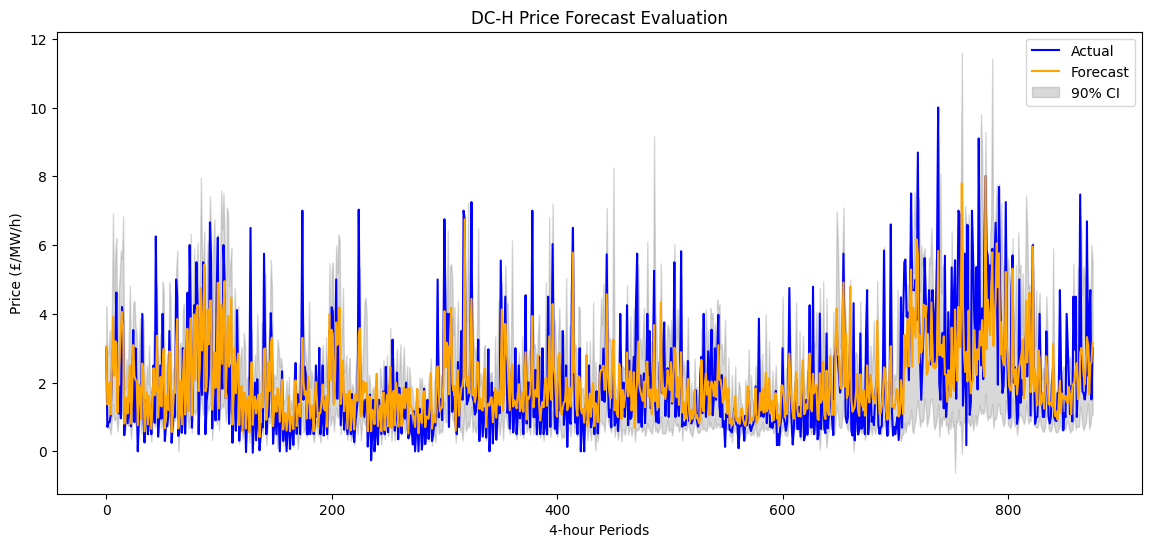


Feature Importance Analysis for DC-H


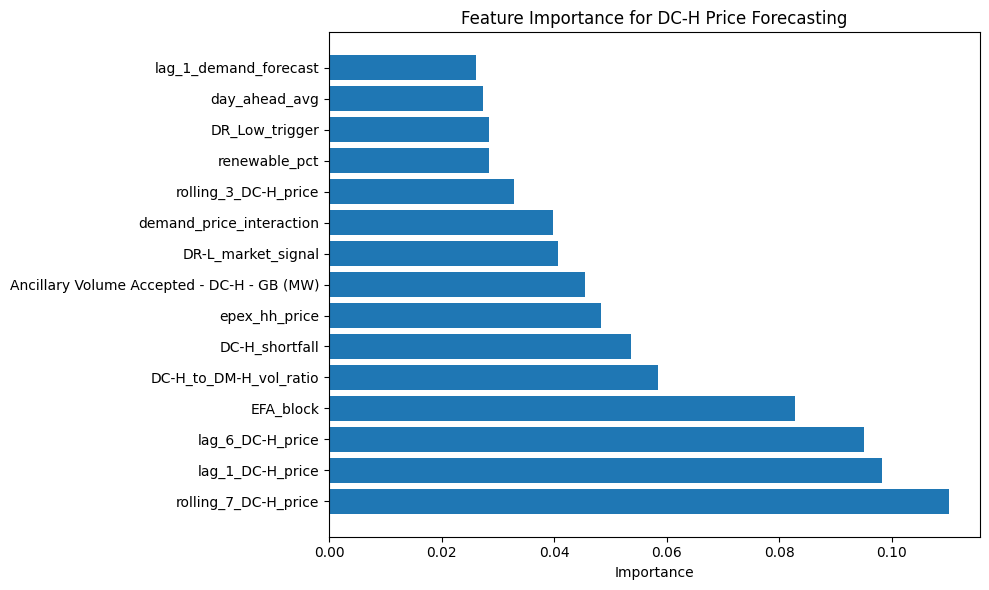

Top 5 most important features:
                   Feature  Importance
30    rolling_7_DC-H_price    0.110171
27        lag_1_DC-H_price    0.098278
28        lag_6_DC-H_price    0.095004
0                EFA_block    0.082803
11  DC-H_to_DM-H_vol_ratio    0.058400


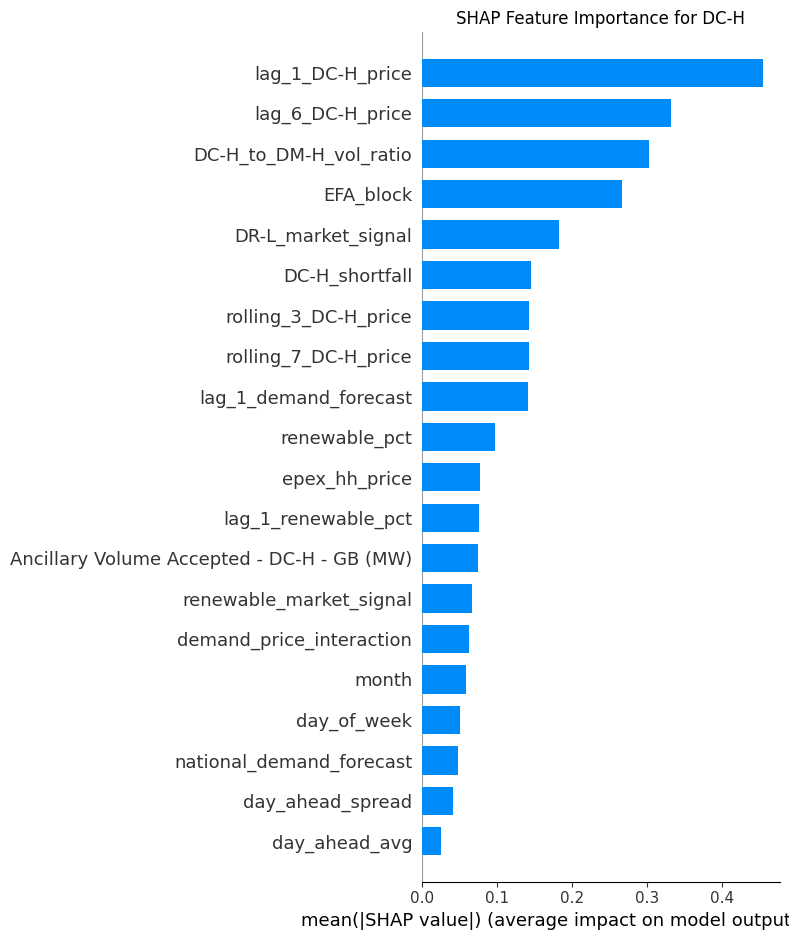

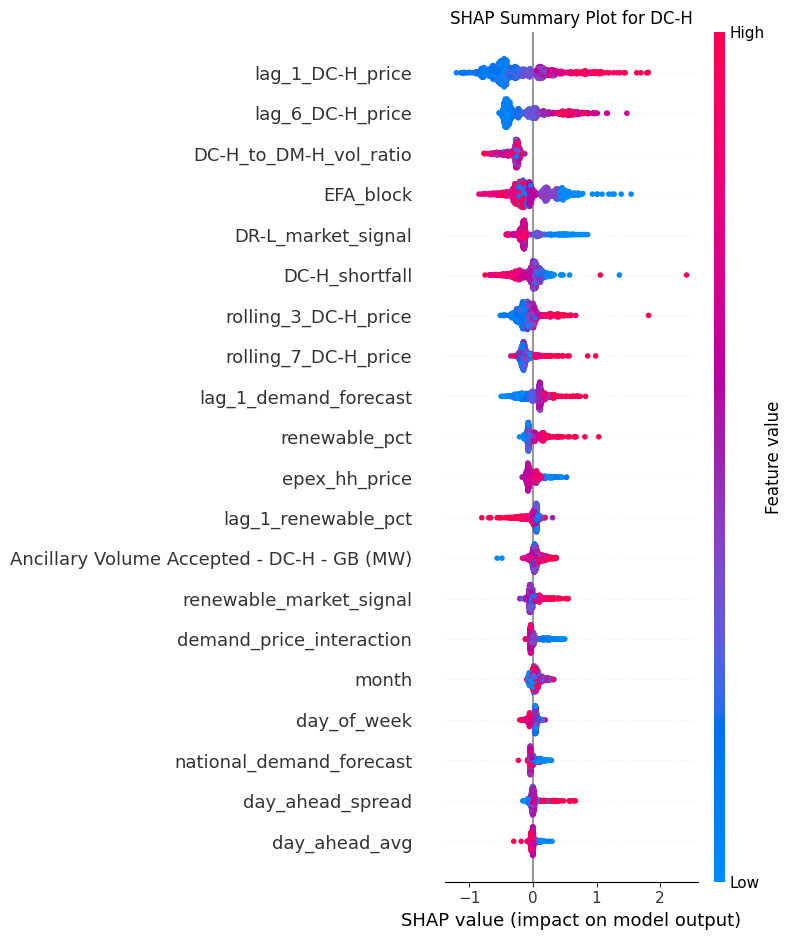


Processing DC-L
Best params for DC-L: OrderedDict([('regressor__learning_rate', 0.06805780428903004), ('regressor__max_depth', 5), ('regressor__n_estimators', 110)])

DC-L Performance:
MAE: £1.22/MW/h | RMSE: £3.04/MW/h | R2: 0.4070


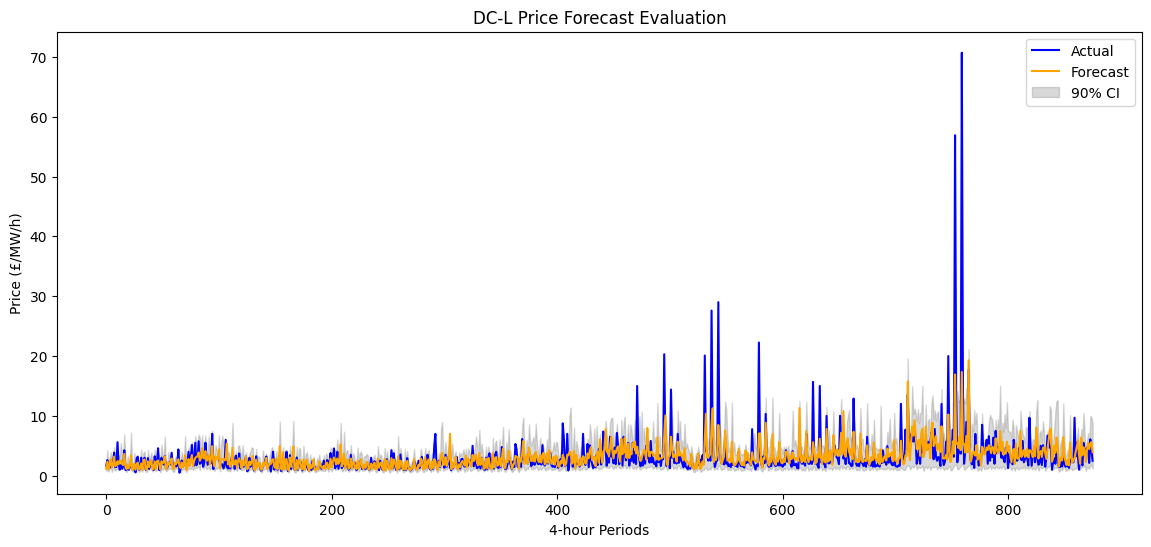


Feature Importance Analysis for DC-L


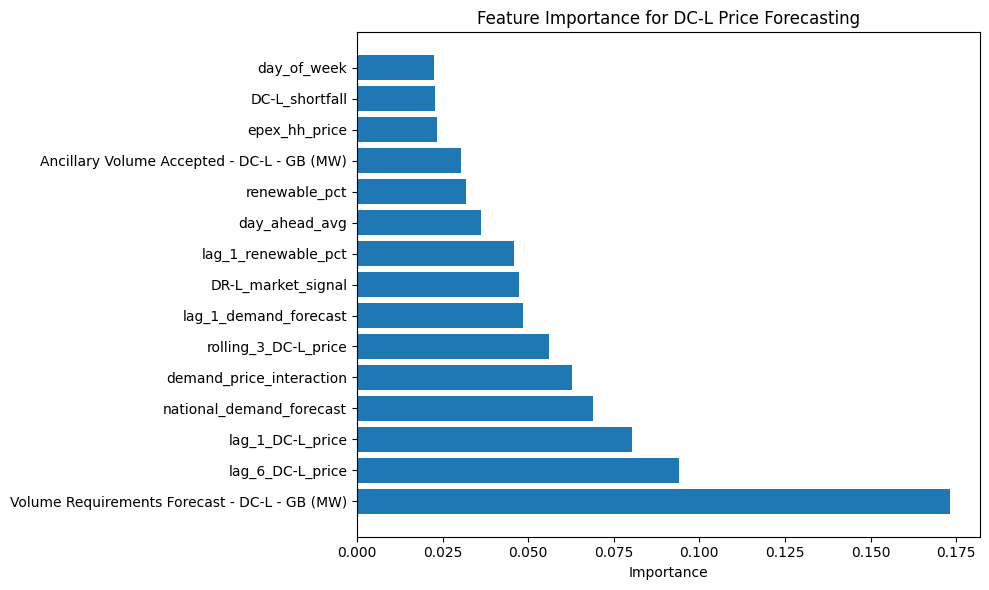

Top 5 most important features:
                                          Feature  Importance
32  Volume Requirements Forecast - DC-L - GB (MW)    0.173317
28                               lag_6_DC-L_price    0.094085
27                               lag_1_DC-L_price    0.080285
15                       national_demand_forecast    0.069079
17                       demand_price_interaction    0.062944


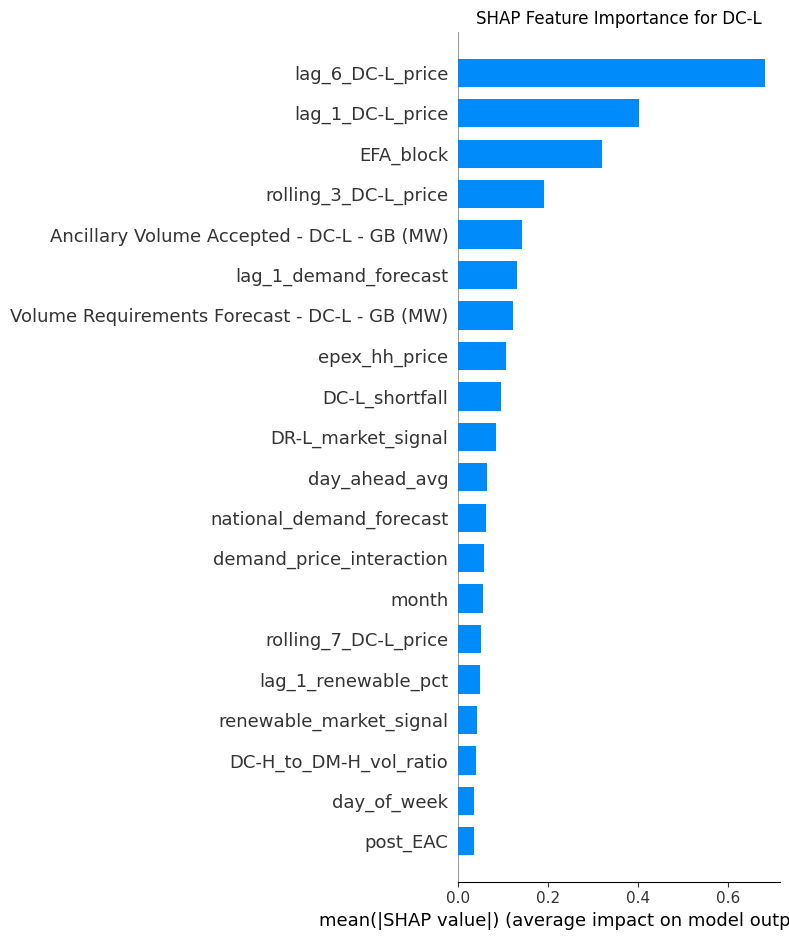

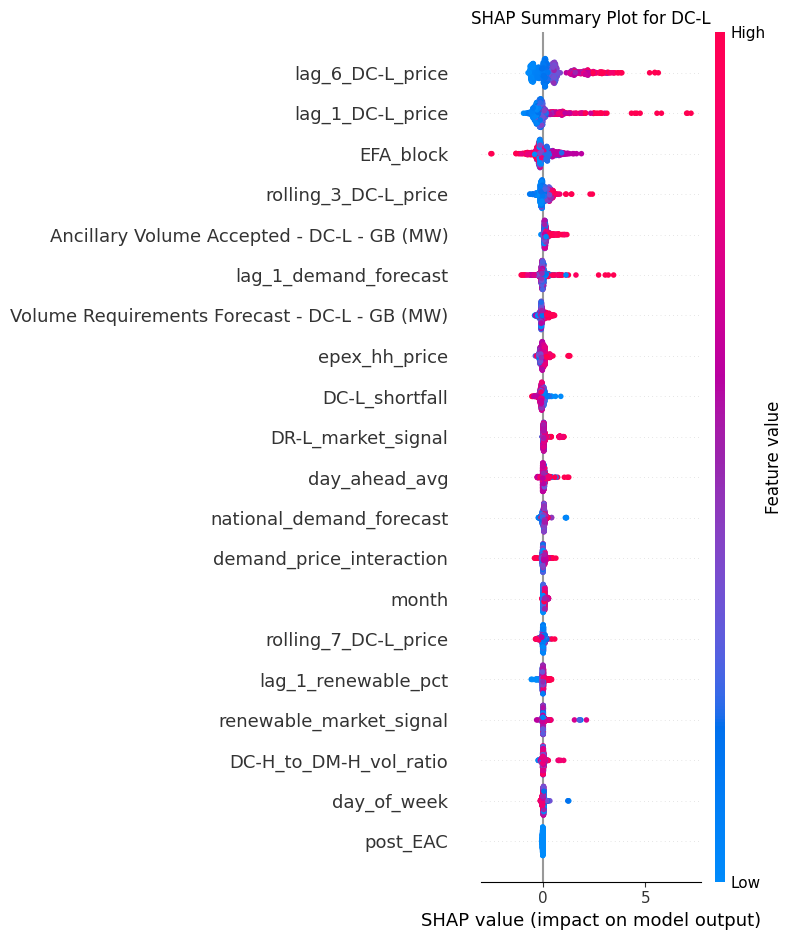


Processing DM-H
Best params for DM-H: OrderedDict([('regressor__learning_rate', 0.08780627736380686), ('regressor__max_depth', 3), ('regressor__n_estimators', 160)])

DM-H Performance:
MAE: £0.88/MW/h | RMSE: £1.27/MW/h | R2: 0.6523


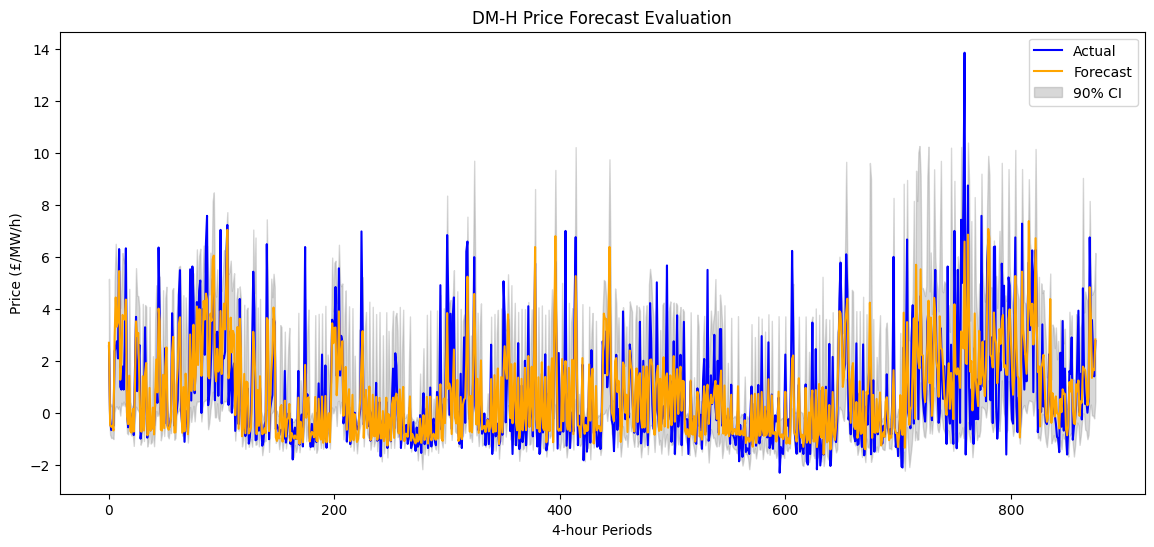


Feature Importance Analysis for DM-H


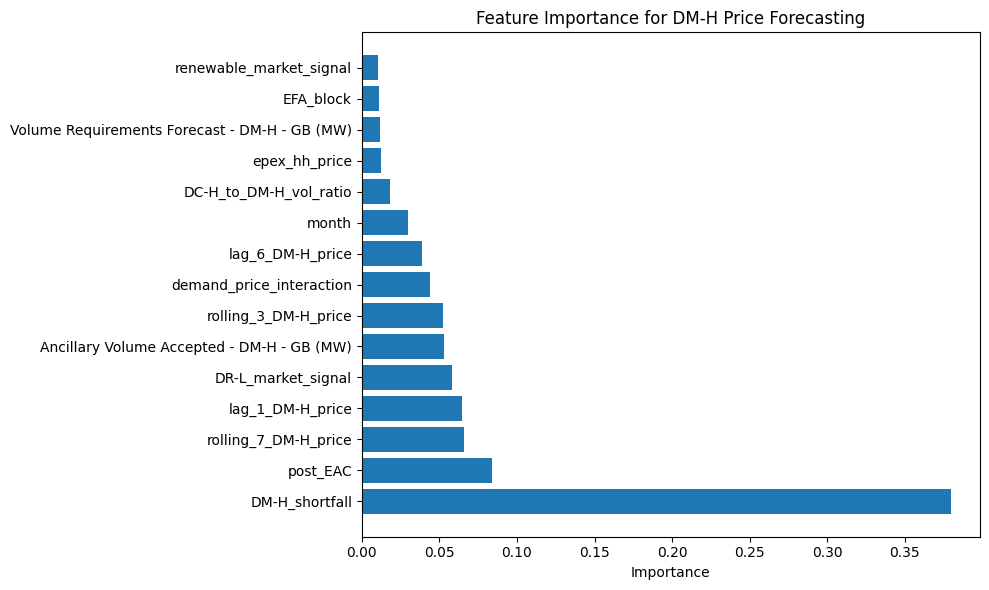

Top 5 most important features:
                 Feature  Importance
31        DM-H_shortfall    0.379510
10              post_EAC    0.083846
30  rolling_7_DM-H_price    0.065890
27      lag_1_DM-H_price    0.064322
12    DR-L_market_signal    0.058278


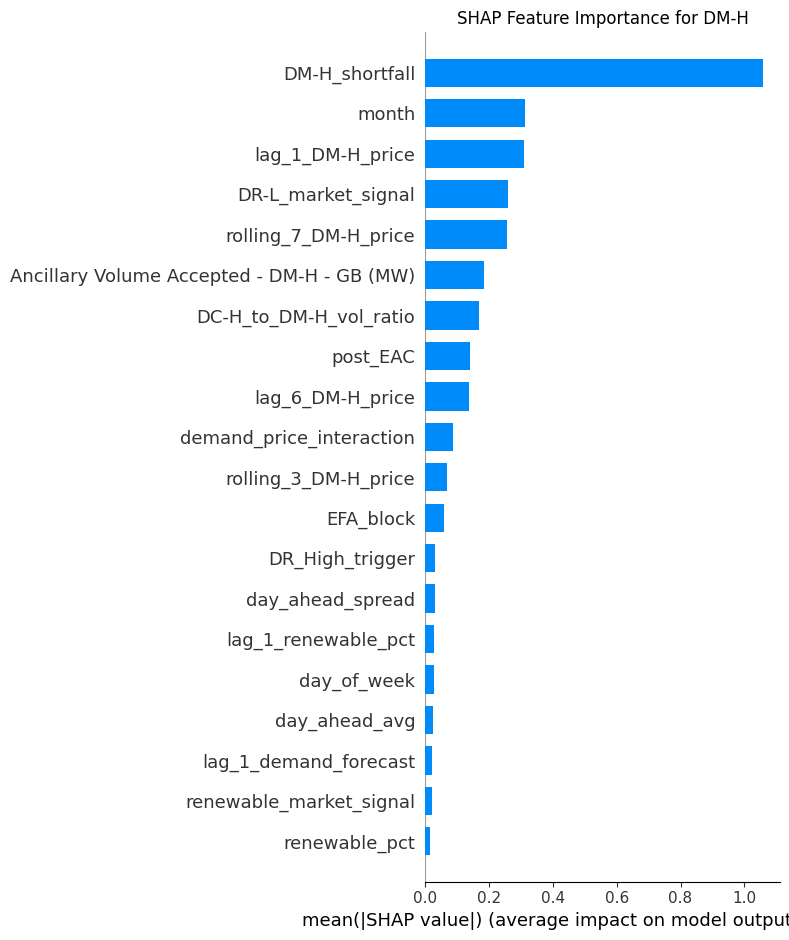

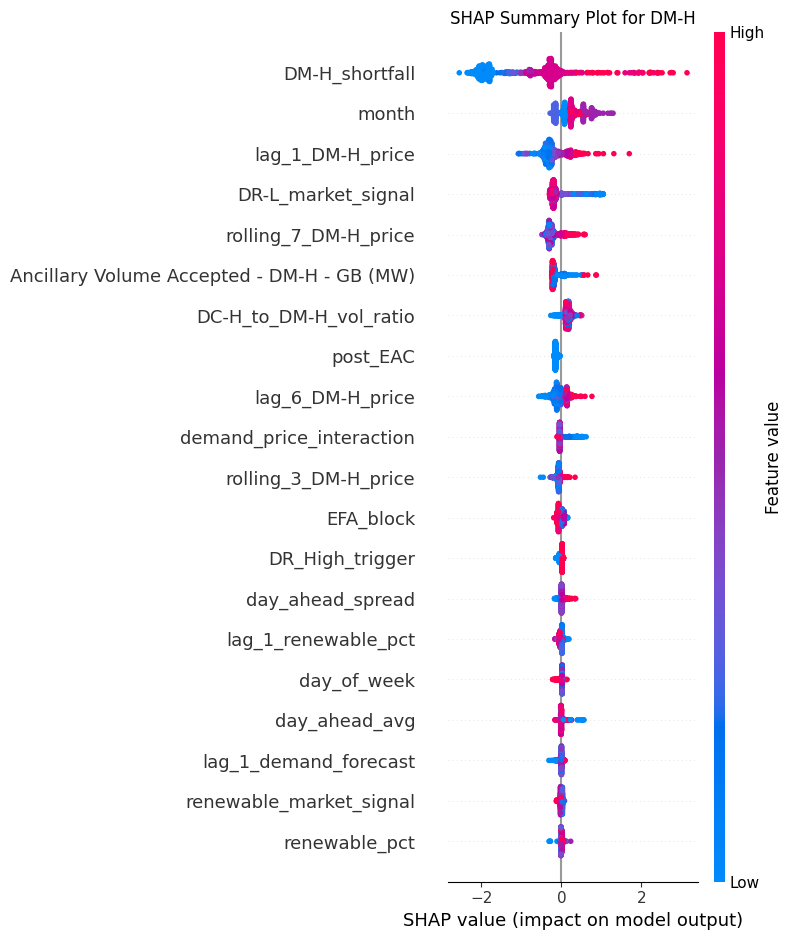


Processing DM-L
Best params for DM-L: OrderedDict([('regressor__learning_rate', 0.08780627736380686), ('regressor__max_depth', 3), ('regressor__n_estimators', 160)])

DM-L Performance:
MAE: £0.88/MW/h | RMSE: £1.72/MW/h | R2: 0.3576


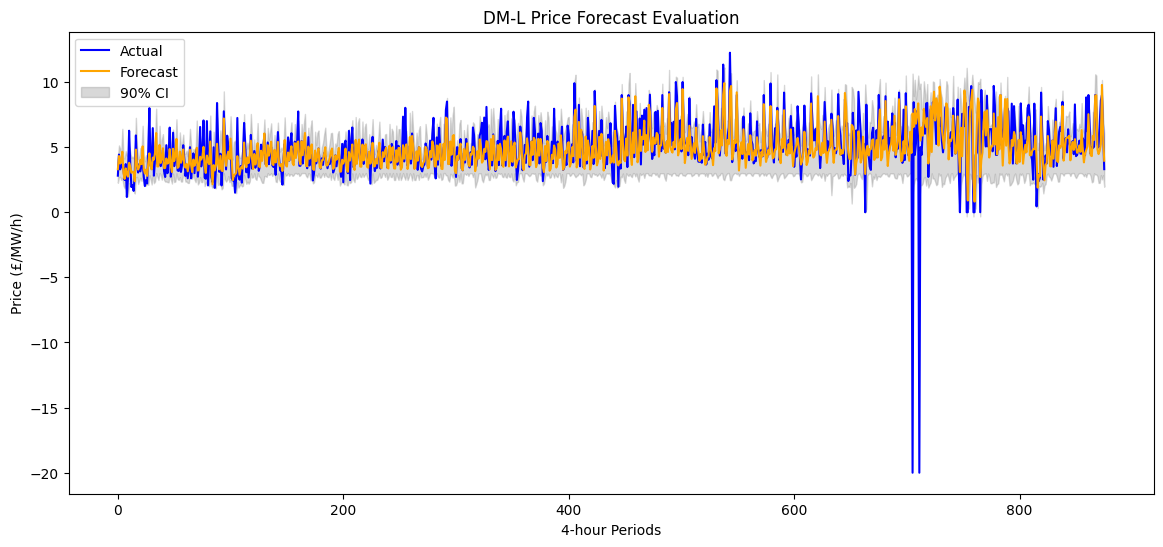


Feature Importance Analysis for DM-L


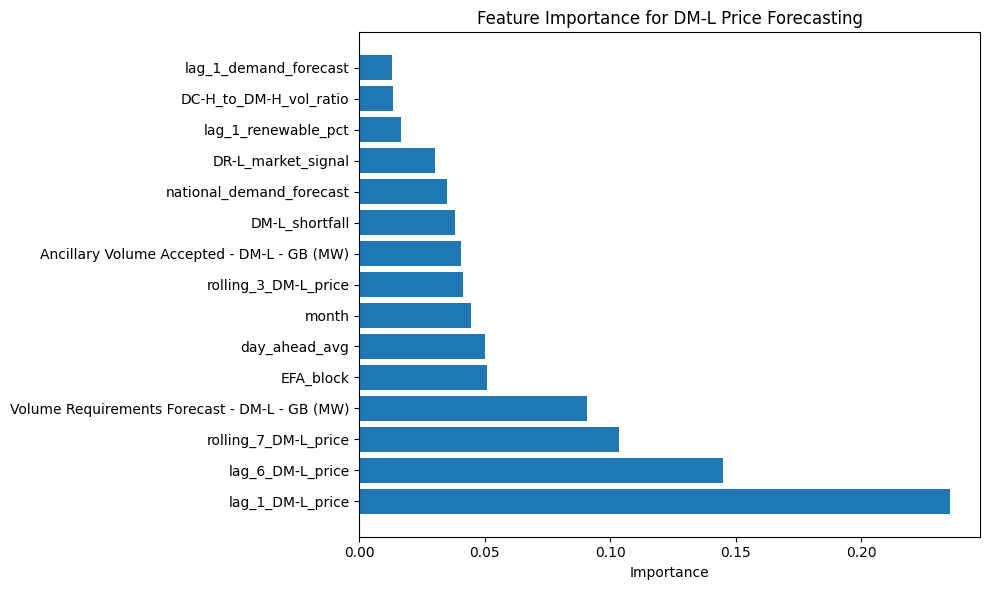

Top 5 most important features:
                                          Feature  Importance
27                               lag_1_DM-L_price    0.235417
28                               lag_6_DM-L_price    0.144939
30                           rolling_7_DM-L_price    0.103622
32  Volume Requirements Forecast - DM-L - GB (MW)    0.090743
0                                       EFA_block    0.050983


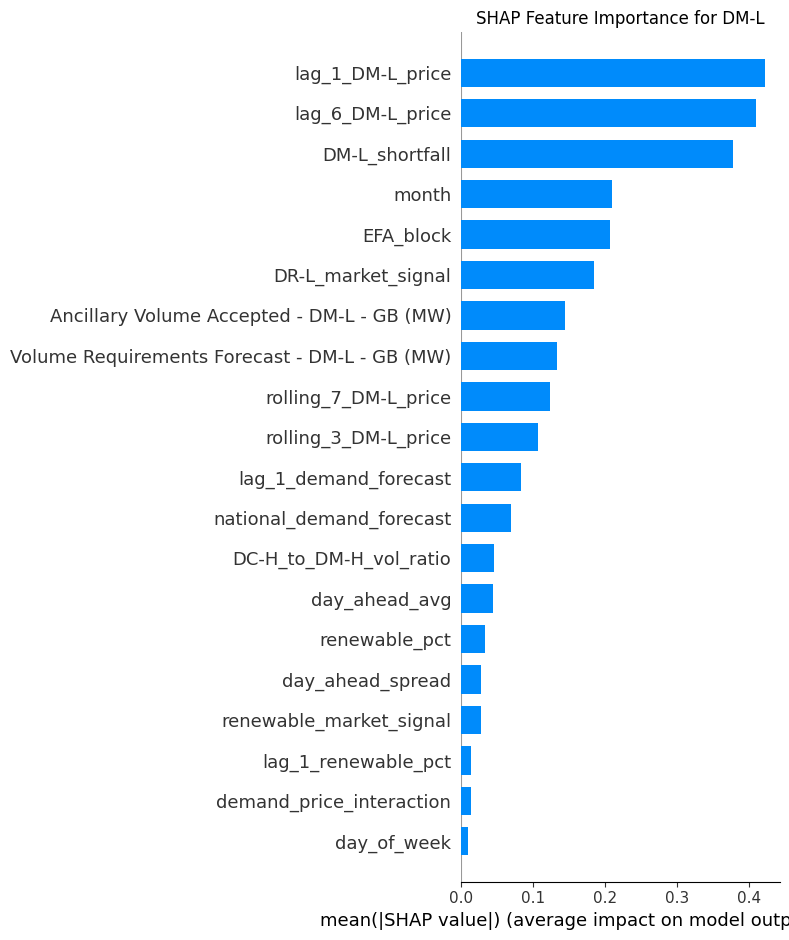

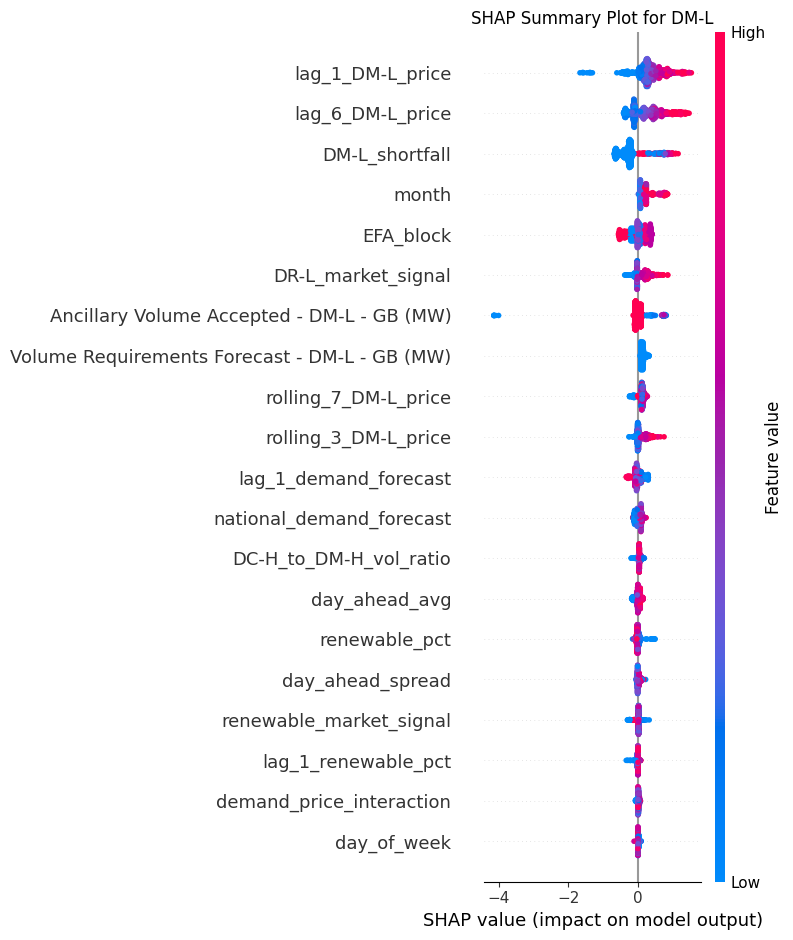


Processing DR-H
Best params for DR-H: OrderedDict([('regressor__learning_rate', 0.017561255472761376), ('regressor__max_depth', 6), ('regressor__n_estimators', 679)])

DR-H Performance:
MAE: £1.77/MW/h | RMSE: £2.36/MW/h | R2: 0.7407


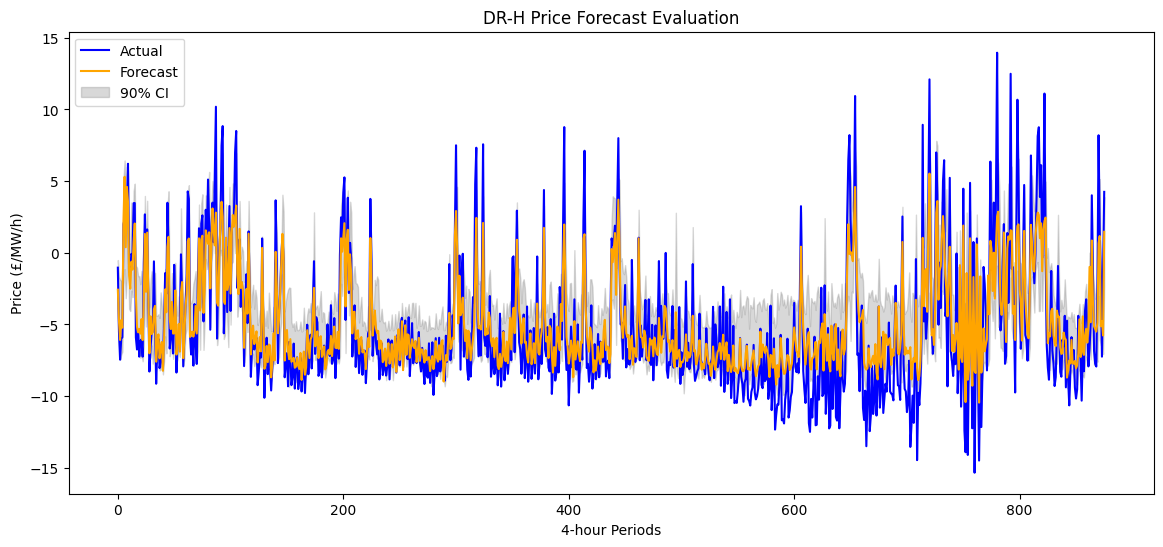


Feature Importance Analysis for DR-H


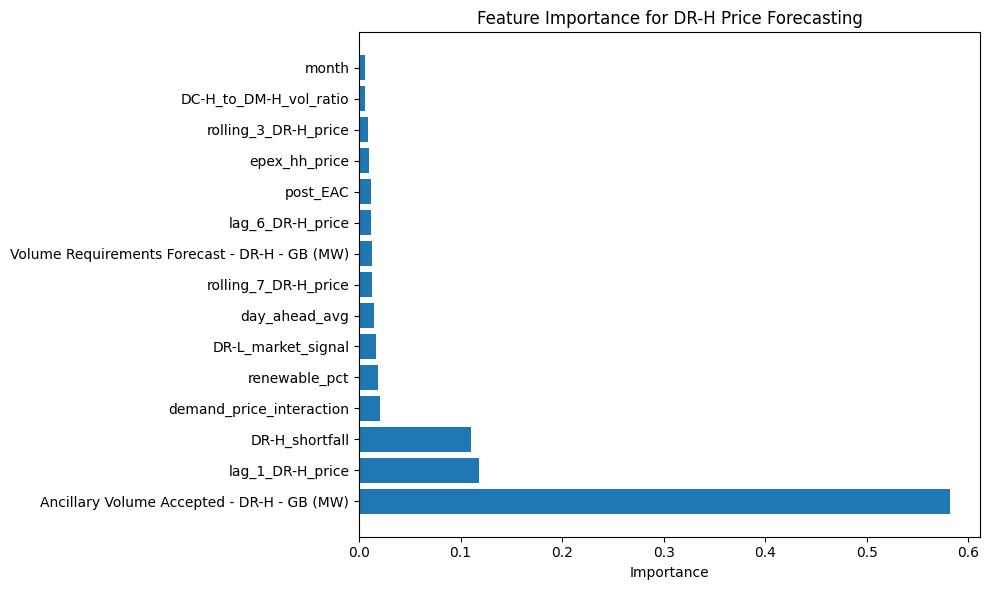

Top 5 most important features:
                                       Feature  Importance
34  Ancillary Volume Accepted - DR-H - GB (MW)    0.582444
28                            lag_1_DR-H_price    0.118311
32                              DR-H_shortfall    0.110146
17                    demand_price_interaction    0.020501
7                                renewable_pct    0.018684


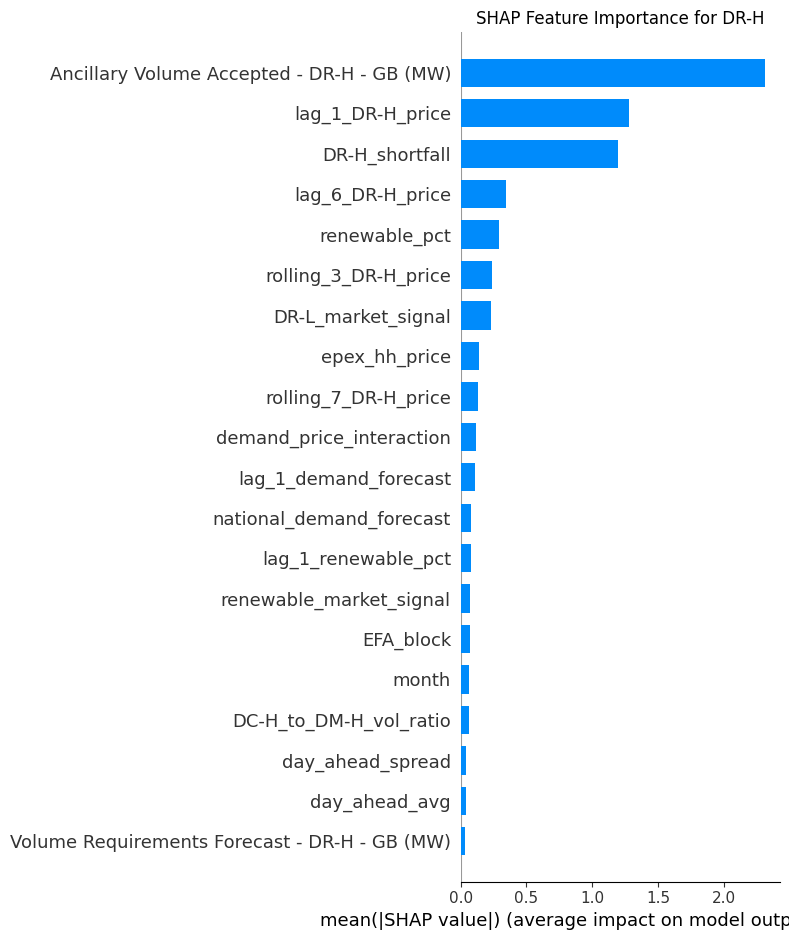

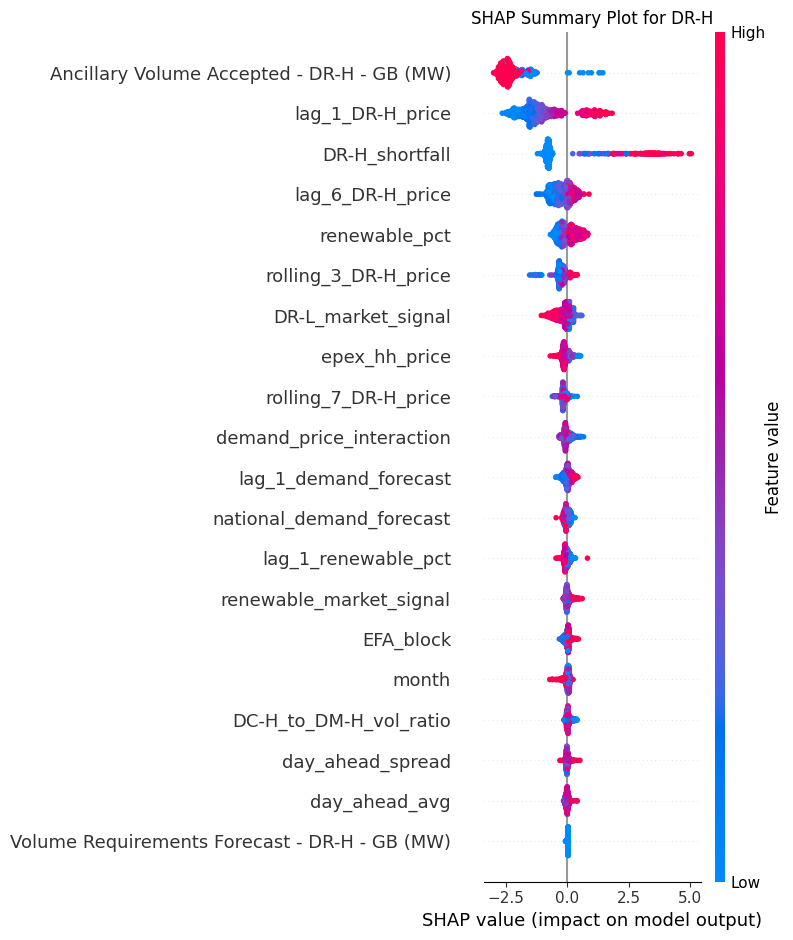


Processing DR-L
Best params for DR-L: OrderedDict([('regressor__learning_rate', 0.017561255472761376), ('regressor__max_depth', 6), ('regressor__n_estimators', 679)])

DR-L Performance:
MAE: £2.16/MW/h | RMSE: £3.59/MW/h | R2: 0.3882


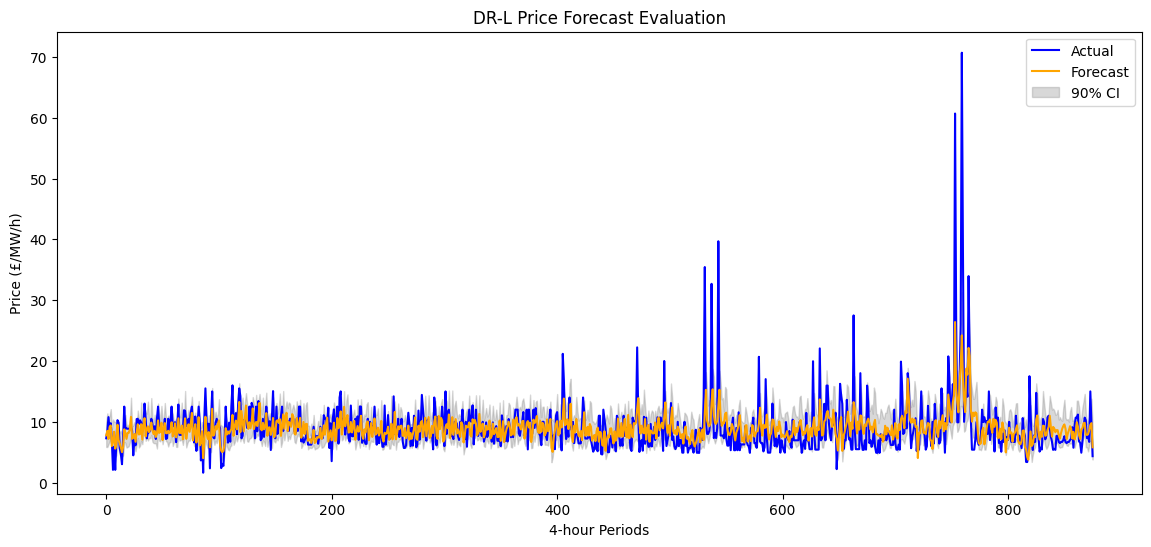


Feature Importance Analysis for DR-L


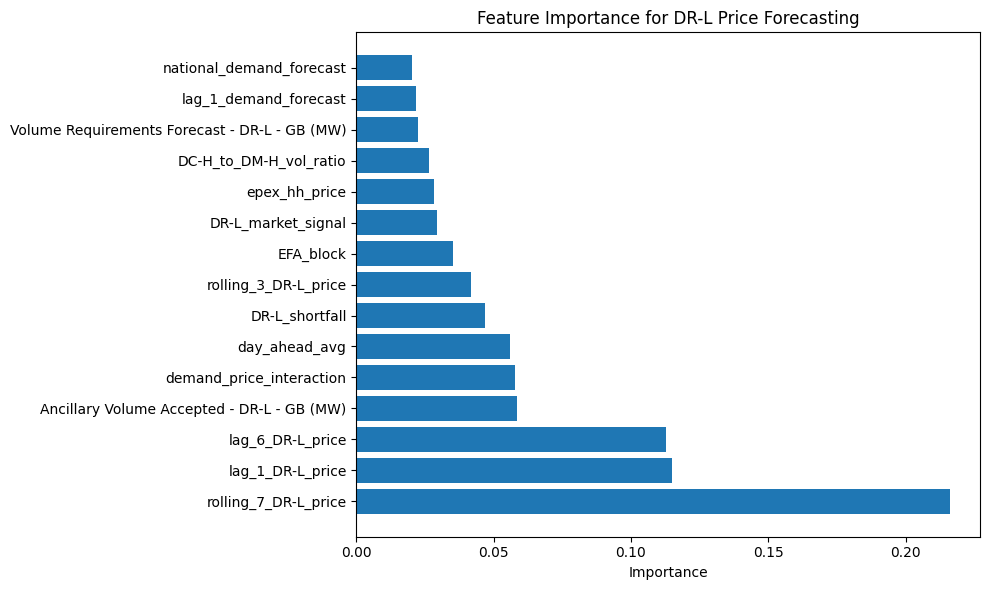

Top 5 most important features:
                                       Feature  Importance
30                        rolling_7_DR-L_price    0.216289
27                            lag_1_DR-L_price    0.114884
28                            lag_6_DR-L_price    0.112618
33  Ancillary Volume Accepted - DR-L - GB (MW)    0.058484
17                    demand_price_interaction    0.057759


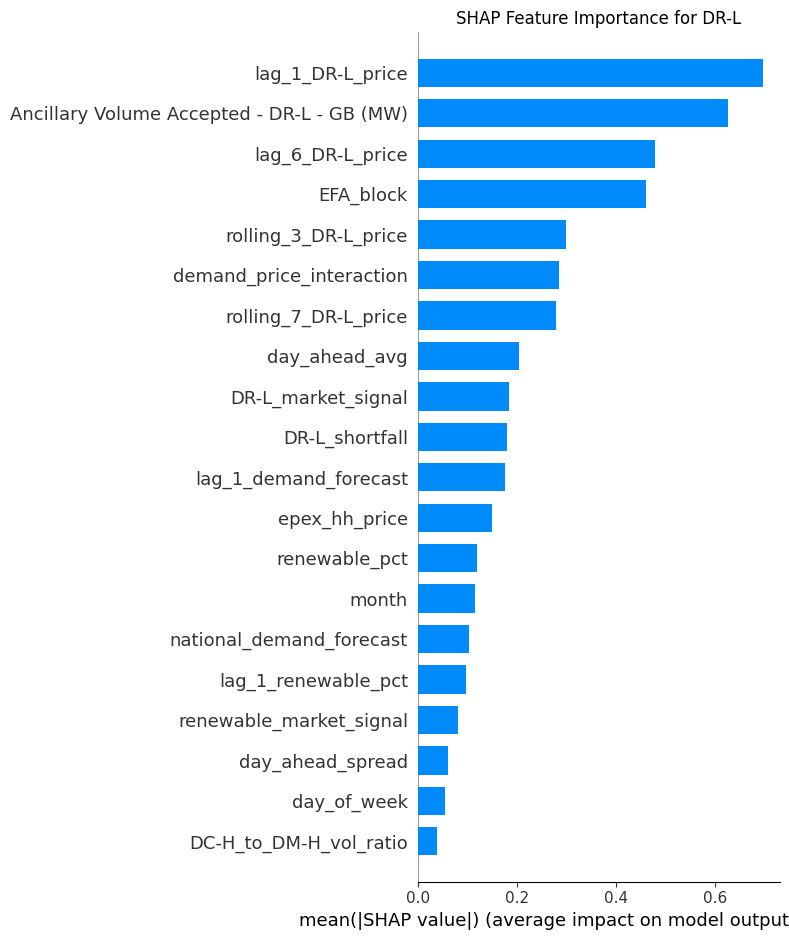

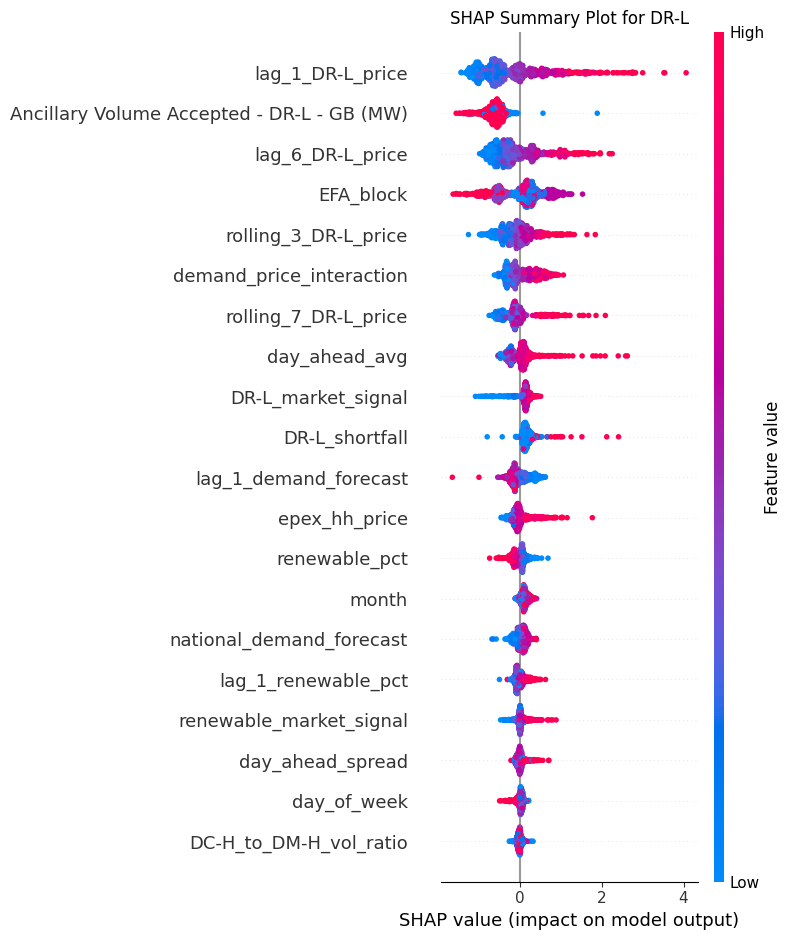

In [17]:
# ========================
# 5. Main Execution Flow
# ========================
services = ['DC-H', 'DC-L', 'DM-H', 'DM-L', 'DR-H', 'DR-L']

for service in services:
    if f'Ancillary Price - {service} - GB (£/MW/h)' not in merged_data.columns:
        continue

    print(f"\n{'='*40}")
    print(f"Processing {service}")
    print(f"{'='*40}")

    # Perform EDA
    # perform_eda(merged_data, service)

    # Train model and generate forecasts
    model, X_train, y_train, X_test, y_test, valid_features = train_model(merged_data, service)
    evaluate_and_forecast(model, X_train, y_train, X_test, y_test, valid_features, service)

    try:
        analyze_feature_importance(model, X_train, X_test, service)
    except Exception as e:
        print(f"Feature importance analysis failed for {service}: {e}")

##Analysis of the Results
###1. Performance Metrics Overview
The models were evaluated across six different DFR services (DC-H, DC-L, DM-H, DM-L, DR-H, and DR-L) using three key metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²). Here’s a summary:

####DC-H:

- MAE: £0.81/MW/h

- RMSE: £1.16/MW/h

- R²: 0.5246

Interpretation: The model for DC-H shows moderate performance. It explains about 52% of the variance, indicating that while the features capture a significant part of the dynamics, there is still room for improvement.

####DC-L:

- MAE: £1.22/MW/h

- RMSE: £3.04/MW/h

- R²: 0.4070

Interpretation: Higher absolute errors and a lower R² suggest that the DC-L prices are more volatile or that the current feature set doesn’t capture all the underlying dynamics as effectively.

####DM-H:

- MAE: £0.88/MW/h

- RMSE: £1.27/MW/h

- R²: 0.6523

Interpretation: With an R² of 0.65, the DM-H model performs comparatively well. The features seem to capture the pre-fault dynamics effectively, contributing to a better overall fit.

####DM-L:

- MAE: £0.88/MW/h

- RMSE: £1.72/MW/h

- R²: 0.3576

Interpretation: Although the MAE is similar to DM-H, the lower R² and higher RMSE indicate that the variability in DM-L prices is not as well explained by the current model.

####DR-H:

- MAE: £1.77/MW/h

- RMSE: £2.36/MW/h

- R²: 0.7407

Interpretation: The DR-H model has the highest R² (74%), suggesting that the model captures the price dynamics effectively. However, the absolute errors are higher, which may be due to inherently higher price levels or more complex patterns in the DR-H market.

####DR-L:

- MAE: £2.16/MW/h

- RMSE: £3.59/MW/h

- R²: 0.3882

Interpretation: Similar to DC-L and DM-L, the DR-L model shows lower explanatory power (R² around 39%) and higher errors, highlighting the challenges in modeling this service—possibly due to higher volatility or missing predictive features.

###2. Hyperparameter Insights
####DC and DM Services:

The models for these services use relatively higher learning rates (around 0.07–0.09), a lower maximum tree depth (3–5), and fewer trees (100–200 estimators).

Implication: These settings suggest that simpler models work adequately, which might be due to more straightforward price dynamics or less noise in the underlying data.

####DR Services:

The DR models require a much lower learning rate (≈0.0176), a higher tree depth (6), and a significantly larger number of estimators (≈679).

Implication: This indicates that DR prices likely have more complex relationships that benefit from a more complex model structure, which can capture subtler nonlinear patterns in the data.

###3. Feature Importance Analysis
The feature importance analysis (including both built-in importance from XGBoost and SHAP values) highlights the key drivers for each service:

####DC-H:

Key Features: Rolling average of lagged prices (e.g., rolling_7_DC-H_price), immediate lagged prices (e.g., lag_1_DC-H_price, lag_6_DC-H_price), and the EFA_block indicator.

Insight: Time-of-day effects and recent price trends are critical in forecasting DC-H prices.

####DC-L:

Key Features: Volume requirements forecast and lagged price features.

Insight: For DC-L, market volume signals are very important, indicating that demand-side information plays a significant role.

####DM-H and DM-L:

Key Features: For DM-H, the shortfall feature (DM-H_shortfall) stands out along with regulatory markers like post_EAC, suggesting that the introduction of EAC has a notable impact. DM-L, while showing similar trends with lagged prices, seems to have a lower overall explanatory power.

Insight: Pre-fault dynamics are better captured in DM-H than DM-L, possibly reflecting differences in market behavior between high and low demand situations.

####DR-H:

Key Features: Ancillary volume accepted (Ancillary Volume Accepted - DR-H - GB (MW)) is the most influential feature, followed by lagged DR-H prices and the shortfall measure.

Insight: The actual market participation (volume accepted) is a critical driver for DR-H prices, reflecting the operational decisions in real time.

####DR-L:

Key Features: Similar lagged price features are important, but the model struggles to capture the complexity fully.

Insight: The lower performance metrics suggest that DR-L might be influenced by factors not adequately represented in the current feature set.